In [32]:
import numpy as np
from random import randrange
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [21]:
class KMeans():
    """
    K-Means clustering implementation for 2-d continuous data using k-means++ to pick starting cluster centers
    """
    def __init__(self):
        self.centers = None
        self.x1 = None
        self.x2 = None
        self.k = None
        self.set_assignments = None
        self.cluster_sets = None
        
    def cluster(self, k, x1, x2):
        self.x1 = x1
        self.x2 = x2
        self.k = k
        # initialize centers randomily choosing first center and picking points furthest from other centers
        idx = randrange(len(x1))
        centers = [[x1[idx],x2[idx]]]
        for i in range(2,k+1):
            D = []
            for j in range(0,len(x1)):
                D_j_arr = []
                for c in centers:
                    D_j_arr.append((x1[j]-c[0])**2 + (x2[j]-c[1])**2)
                D.append(min(D_j_arr))
            idx_Ci = np.argmax(D)
            centers.append([x1[idx_Ci],x2[idx_Ci]])
        
        # perform Lloyd's algorithm (k-means)
        prev_centers = None
        set_assignments = []
        S = dict() #cluster point sets
        while prev_centers != centers:
            prev_centers = []
            for i in range(k):
                prev_centers.append(centers[i])
            # step 1: assign points to each cluster
            for i in range(0,k):
                S[i] = []
            set_assignments = []
            for i in range(len(x1)):
                dists_i = []
                for c in centers:
                    dists_i.append((x1[i]-c[0])**2 + (x2[i]-c[1])**2)
                set_assignments.append(np.argmin(dists_i))
            for i in range(len(x1)):
                S[set_assignments[i]].append([x1[i],x2[i]])
            # step 2: update cluster centroids
            for i in range(k):
                x,y = 0,0
                for point in S[i]:
                    x += point[0]
                    y += point[1]
                centers[i] = [x/len(S[i]),y/len(S[i])]
        self.cluster_sets = S
        self.set_assignments = set_assignments
        self.centers = centers
            
    def get_centers(self):
        return self.centers
    
    def accuracy(self,labels):
        # find the closest center to each distribution
        proba_dist_centroids = []
        for i in range(self.k):
            dists = []
            for c in self.centers:
                dists.append((np.mean(x1[i*100:(i+1)*100])-c[0])**2 + (np.mean(x2[i*100:(i+1)*100])-c[1])**2)
            proba_dist_centroids.append(np.argmin(dists))
        # label the set assignments according to their centers corresponding distribution
        predicted_dist = self.set_assignments
        dist_names = ['a','b','c']
        for i in range(self.k):
            letter = dist_names[i]
            predicted_dist = [(j,letter)[j==proba_dist_centroids[i]] for j in predicted_dist]
        # find the precentage of matching labels
        return sum(x == y for x, y in zip(predicted_dist, labels)) / len(labels)
    
    def objective_val(self,):
        sum_of_euclidean_dists = 0
        for i in range(self.k):
            c = self.centers[i]
            for j in range(len(self.cluster_sets[i])):
                point = self.cluster_sets[i][j]
                sum_of_euclidean_dists += (c[0]-point[0])**2 + (c[1]-point[1])**2
        return sum_of_euclidean_dists

In [22]:
def get_synth_data(sigma, N):
    N=int(N/3)
    # P_a distribution
    mean_a = np.array([-1,-1])
    cov_a = sigma * np.array([[2,0.5], [0.5,1]])
    x_a, y_a = np.random.multivariate_normal(mean_a, cov_a, N).T
    
    # P_b distribution
    mean_b = np.array([1,-1])
    cov_b = sigma * np.array([[1,-0.5], [-0.5,2]])
    x_b, y_b = np.random.multivariate_normal(mean_b, cov_b, N).T
    
    # P_c distribution
    mean_c = np.array([0,1])
    cov_c = sigma * np.array([[1,0], [0,2]])
    x_c, y_c = np.random.multivariate_normal(mean_c, cov_c, N).T
    
    x = np.concatenate((x_a,np.concatenate((x_b,x_c), axis=0)),axis=0)
    y = np.concatenate((y_a,np.concatenate((y_b,y_c), axis=0)),axis=0)
    
    return (x, y)

In [23]:
sigmas = [0.5, 1, 2, 4, 8]
N = 300

# generate distribution labels corrresponding to (x1,x2) pair
letters = ['a','b','c']
labels = []
for l in letters:
    for i in range(0,100):
        labels.append(l)
        
accs = []
obj_vals = []
for sigma in sigmas:
    x1,x2 = get_synth_data(sigma, N)
    model = KMeans()
    model.cluster(k=3,x1=x1,x2=x2)
    
    # evaluate based on clustering objective
    obj_vals.append(model.objective_val())
    
    # evaluate based on clustering accuracy based on the 3 dists
    accs.append(model.accuracy(labels))

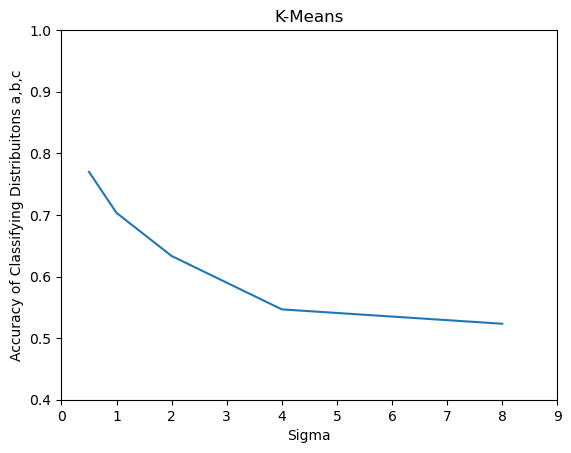

In [33]:
# Plotting Accuracy
plt.plot(sigmas,accs)
plt.xlabel("Sigma")
plt.ylabel("Accuracy of Classifying Distribuitons a,b,c")
plt.title("K-Means")
plt.xticks(np.arange(0, 9.1, 1))
plt.yticks(np.arange(0.4, 1.01, .1));

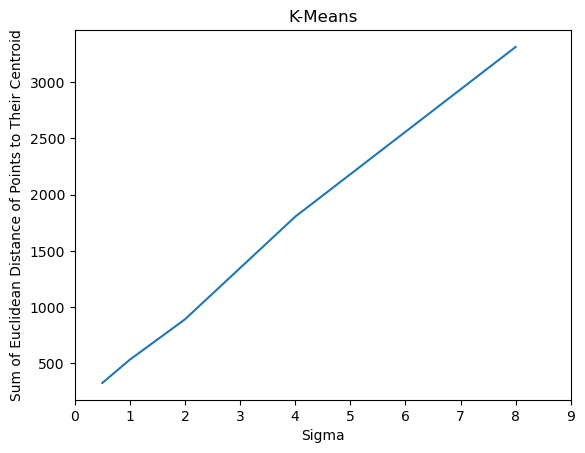

In [34]:
# Plotting Objective Values (sum of duclidean distances from datapoints to their centers)
plt.plot(sigmas,obj_vals)
plt.xlabel("Sigma")
plt.ylabel("Sum of Euclidean Distance of Points to Their Centroid")
plt.title("K-Means")
plt.xticks(np.arange(0, 9.1, 1));

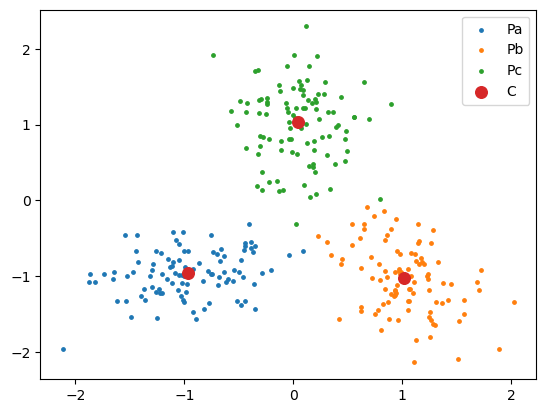

In [31]:
# Model Example
k = 3
sigma=.1
x1,x2 = get_synth_data(sigma, 300)
model = KMeans()
model.cluster(k,x1,x2)
c = np.array(model.get_centers())
plt.scatter(x1[0:100],x2[0:100],s=6,label='Pa')
plt.scatter(x1[100:200],x2[100:200],s=6,label='Pb')
plt.scatter(x1[200:300],x2[200:300],s=6,label='Pc')
plt.scatter(c[:,0],c[:,1],s=70,label='C')
plt.legend();